In [521]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
from geodatasets import get_path
import numpy as np
import xarray as xr

import sys
sys.path.append('..')
from scripts.dicts import *
from scripts.great_circle_distance import great_circle_distance
from scripts.paths import *

In [522]:
pathKing = '/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/raw/solid_discharge/King2020_doi_10_5061_dryad_qrfj6q5cb__v20200429/GrIS_D_1985-2018.xlsx'

In [523]:
fpath_adj_sect  = '/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/temp/adjusted_section_numbers_slater.nc'
fpath_masks1k = '/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/temp/masks1k.nc'
folder_MARRACMO1km = "/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/raw/liquid/"

ds_adj_sect = xr.open_dataset(fpath_adj_sect)
ds_masks1k = xr.open_dataset(fpath_masks1k)

In [524]:
def find_corresponding_section(ds_section, da_lat, da_lon, target_lat, target_lon):
    """Find the section in ds_section that is closest to the target location (target_lat, target_lon).
    
    Parameters
    ----------
    ds_section : xarray.Dataset
        Dataset with sections as values.
    da_lat : xarray.DataArray
        Latitude values of the sections.
    da_lon : xarray.DataArray
        Longitude values of the sections.
    target_lat : float
        Latitude of the target location.
    target_lon : float
        Longitude of the target location.
    
    Returns
    -------
    xarray.DataArray
        The section that is closest to the target location.
    """
    # Calculate the distance between the target location and all sections
    distances = great_circle_distance(da_lat, da_lon, target_lat, target_lon)
    indx_to_min = distances.argmin(dim=['x', 'y'])
    
    # Find the section with the smallest distance
    closest_section = int(ds_section[indx_to_min].values)

    # assert that closest distance is less than 20 km
    assert distances.min() < 20, f"Closest distance is {distances.min():.2f} km, which is more than 20 km"
    
    return closest_section


find_corresponding_section(ds_adj_sect['section_numbers_adjusted'], ds_masks1k.LAT, ds_masks1k.LON, 64.1, -50.5)

2

# Import metadata s.a. longitude etcetera and match with basin_nr

In [525]:
ds_King_meta = pd.read_excel(pathKing, header=[0, 1], nrows=1, index_col=0)
ds_King_meta =ds_King_meta.T.unstack(level=1)
ds_King_meta.columns = ds_King_meta.columns.droplevel()
def remove_quotes(x):
    return x.strip("'")
def remove_quotes_columns(ds):
    ds.columns = remove_quotes(ds.columns.str)
def remove_quotes_index(ds):
    ds.index = remove_quotes(ds.index.str)
remove_quotes_columns(ds_King_meta)
remove_quotes_index(ds_King_meta)
ds_King_meta['basin_nr'] = ds_King_meta.apply(lambda x: find_corresponding_section(ds_adj_sect['section_numbers_adjusted'], ds_masks1k.LAT, ds_masks1k.LON, x.latitude, x.longitude), axis=1)
ds_King_meta

coordinates,latitude,longitude,basin_nr
Number_Name,,,
001_79fjorden,79.501618,-23.392803,5
002_academy,81.552332,-33.046728,7
003_alangordliup,68.814959,-50.269235,4
004_alangorssupsermia,73.098737,-54.966186,6
005_alison,74.656297,-55.988739,6
...,...,...,...
230_vestifjord,70.307794,-29.577861,3
231_walterhausen,74.086350,-25.375273,5
232_west krista dan,69.965698,-28.311832,3


# Import Discharge Data

In [526]:
import os
ds_D_king_xlsx = pd.read_excel(pathKing, header=[0,3], index_col=0, parse_dates=True)
glacier_names = remove_quotes(ds_D_king_xlsx.columns.levels[0].str)
ds_D_king_xlsx.columns = ds_D_king_xlsx.columns.set_levels(glacier_names, level=0)
ds_D_king_xlsx.columns = ds_D_king_xlsx.columns.set_levels(remove_quotes(ds_D_king_xlsx.columns.levels[1].str), level=1)
ds_D_king = ds_D_king_xlsx.unstack(level=0).reset_index().rename(columns={'level_0':'basin_nr', 'level_1':'Value_Uncertainty', 0:'Value'})
ds_D_king = pd.merge(ds_D_king, ds_King_meta['basin_nr'].reset_index(), on='Number_Name')
if not os.path.isfile(pathDataTemp + 'King2020_basins.csv'):
    ds_D_king.to_csv(pathDataTemp + 'King2020_basins.csv', index=False)


/var/folders/cv/s_h5gzxd0h71t_d875wqxgzh0000gn/T/ipykernel_98957/1035128201.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



# Correction on total values

In [527]:
# Calculate the fraction of the total discharge that each glacier contributes between 2000 and 2005
df_D_2000_2005_mean = ds_D_king[ds_D_king.Value_Uncertainty=='Discharge (Gt/yr)'][(ds_D_king['Time'] > '2000')&(ds_D_king['Time'] < '2006')].groupby(['Number_Name'])['Value'].mean()
df_D_fraction_per_glacier = df_D_2000_2005_mean /df_D_2000_2005_mean.sum()

# Calculate the coverage of the King dataset
ds_D_king_coverage = ds_D_king[ds_D_king.Value_Uncertainty=='Discharge (Gt/yr)'].pivot(index='Time', columns='Number_Name', values='Value')
ds_D_king_coverage= (ds_D_king_coverage.notna()*df_D_fraction_per_glacier).sum(axis=1)
ds_D_king_coverage[ds_D_king_coverage.index > '2000'] = 1



/var/folders/cv/s_h5gzxd0h71t_d875wqxgzh0000gn/T/ipykernel_98957/339142413.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [528]:
df_D_King_monthly_GrIS =  ds_D_king[ds_D_king.Value_Uncertainty=='Discharge (Gt/yr)'].pivot(index='Time', columns='Number_Name', values='Value').sum(axis=1)/(ds_D_king_coverage)
df_D_King_monthly_GrIS.plot(label='Monthly, corrected')
df_D_King_annual_GrIS = df_D_King_monthly_GrIS.resample('YS').mean()
df_D_King_annual_GrIS.plot(label='Annual, corrected')
plt.legend()


Error in callback <function flush_figures at 0x17aa7c040> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

# Per basin

In [501]:
ds_D_king_per_basin = ds_D_king.set_index(['Number_Name', 'Value_Uncertainty', 'Time'])
# only select discharge from multiindex
ds_D_king_per_basin = ds_D_king_per_basin.loc[(slice(None), "Discharge (Gt/yr)"), :]
ds_D_king_per_basin_sum_uncorrected = ds_D_king_per_basin.groupby([ 'Time', 'basin_nr']).sum() 
ds_D_king_per_basin_mean = ds_D_king_per_basin.groupby([ 'Time', 'basin_nr']).mean()

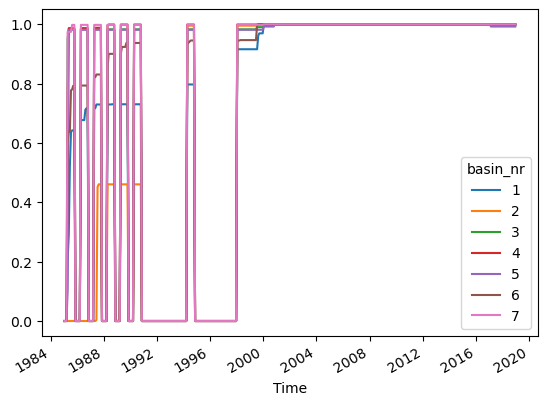

In [529]:
ds_King_meta['2000_2005_mean'] = df_D_2000_2005_mean
sum_per_basin = ds_King_meta.groupby('basin_nr')['2000_2005_mean'].sum().rename('Basin_sum_2000_2005')
df_D_fraction_of_basin = pd.merge(ds_King_meta.reset_index(), sum_per_basin, on='basin_nr')
df_D_fraction_of_basin['fraction_of_basin'] = df_D_fraction_of_basin['2000_2005_mean']/df_D_fraction_of_basin['Basin_sum_2000_2005']
df_D_fraction_of_basin = df_D_fraction_of_basin.set_index('Number_Name')['fraction_of_basin']

ds_D_king_basin_coverage = (ds_D_king[ds_D_king.Value_Uncertainty=='Discharge (Gt/yr)'].pivot(index='Time', columns='Number_Name', values='Value').notna()*df_D_fraction_of_basin).T.groupby(ds_King_meta['basin_nr'] ).sum().T
ds_D_king_basin_coverage.plot()
ds_D_king_basin_coverage[ds_D_king_basin_coverage.index > '2000'] = 1

ds_D_king_per_basin_sum = (ds_D_king_per_basin_sum_uncorrected.reset_index().pivot(index='Time', columns='basin_nr', values='Value').T/ds_D_king_coverage).T




In [544]:
ds_D_king_basin_coverage[ds_D_king_basin_coverage>0]['1985': '1995'].mean()

basin_nr
1    0.702828
2    0.559969
3    0.982293
4    0.988894
5    0.963523
6    0.862383
7    0.996093
dtype: float64

<Axes: xlabel='Time'>

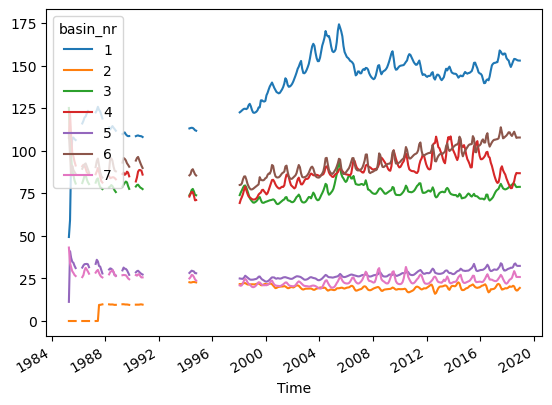

In [534]:
ds_D_king_per_basin_sum.plot()
# ds_D_king_per_basin_sum.sum(axis=1).plot()



In [264]:
px.line(ds_D_king_per_basin_sum.reset_index(), x='Time', y='Value', color='basin_nr')


/Users/annek/opt/anaconda3/envs/phdIIfresh/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [557]:

ds_D_king_per_basin_sum_annual =  ds_D_king_per_basin_sum.resample('YS').mean()
ds_D_king_sum_annual_total = ds_D_king_per_basin_sum_annual.sum(axis=1)
ds_D_king_sum_annual_total[ds_D_king_sum_annual_total == 0] = np.nan


basin_nr,1,2,3,4,5,6,7
Time,,,,,,,
1985-01-01,90.313299,0.000000,94.906730,102.699087,31.706241,92.428881,31.402197
1986-01-01,120.229647,0.000000,82.933937,89.205946,32.778038,90.302067,28.683507
1987-01-01,122.759617,5.490905,80.448445,85.715408,32.401223,89.742163,27.797839
1988-01-01,113.187039,9.644239,78.157256,84.167347,29.151883,91.543284,28.238834
1989-01-01,109.544071,9.707060,80.078182,86.533743,29.700202,93.361633,26.207161
1990-01-01,108.649163,9.649861,78.864642,86.543842,28.483356,93.579593,26.584955
1991-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [558]:

fig = go.Figure()
# convert to go scatter px.line(ds_D_king_per_basin_sum_annual.reset_index(), x='Time', y='Value', color='basin_nr')
for basin_nr in ds_D_king_per_basin_sum_annual.columns.unique():
    fig.add_trace(go.Scatter(x=ds_D_king_per_basin_sum_annual.index, y=ds_D_king_per_basin_sum_annual[basin_nr], mode='lines', name=basin_nr))

fig.add_trace(go.Scatter(x=ds_D_king_sum_annual_total.index, y=ds_D_king_sum_annual_total, mode='lines', name='Total'))
fig.show()

In [261]:
nr_per_basin_King = ds_King_meta.groupby('basin_nr').count()
nr_per_basin_King.drop(columns=['latitude']).rename(columns={'longitude':'nr_glaciers'})

coordinates,nr_glaciers
basin_nr,
1,57
2,19
3,46
4,19
5,14
6,71
7,8


In [353]:
h5 = "/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/raw/solid_discharge/King2020_doi_10_5061_dryad_qrfj6q5cb__v20200429/individual_glaciers/001_79fjorden.h5"
fpath_ind_glaciers = "/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/raw/solid_discharge/King2020_doi_10_5061_dryad_qrfj6q5cb__v20200429/individual_glaciers/"

In [357]:
import h5py
import os
from tqdm import tqdm
import numpy as np

# Path to the folder containing the HDF5 files
folder_path = fpath_ind_glaciers

# Lists to store data from all files
all_ice_discharge = []
all_ice_discharge_err = []

# Loop through all files in the folder
for file_name in tqdm(os.listdir(folder_path)):
    if file_name.endswith('.h5'):
        file_path = os.path.join(folder_path, file_name)
        
        # Open the HDF5 file
        with h5py.File(file_path, 'r') as f:
            # Extract 'ice_discharge' and 'ice_discharge_err' datasets
            ice_discharge = f['discharge/ice_discharge'][:]
            ice_discharge_err = f['discharge/ice_discharge_err'][:]
            
            # Append the data to the lists
            all_ice_discharge.append(ice_discharge)
            all_ice_discharge_err.append(ice_discharge_err)

# Combine all the data into one large numpy array for each dataset
combined_ice_discharge = np.concatenate(all_ice_discharge, axis=0)
combined_ice_discharge_err = np.concatenate(all_ice_discharge_err, axis=0)

# Now combined_ice_discharge and combined_ice_discharge_err hold the data from all files
print("Combined ice discharge data shape:", combined_ice_discharge.shape)
print("Combined ice discharge error data shape:", combined_ice_discharge_err.shape)


100%|██████████| 234/234 [01:11<00:00,  3.29it/s]

Combined ice discharge data shape: (234, 408)
Combined ice discharge error data shape: (234, 408)


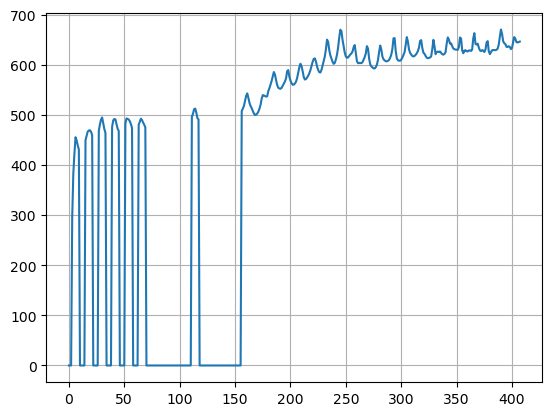

In [384]:
# plt.ylim(450, 550)
plt.grid()
plt.plot(np.nansum(combined_ice_discharge/78*100, axis=0))
plt.show()



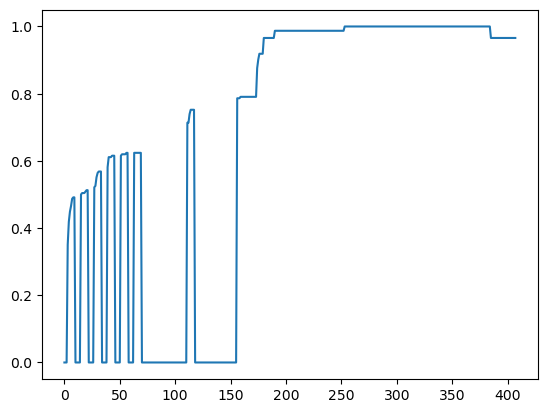

In [383]:
values = 1- (np.isnan(combined_ice_discharge).sum(axis=0) / combined_ice_discharge.shape[0])
plt.plot(values)